In [1]:
import glob
import sys
import os
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter
%matplotlib inline

def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
pkgs = ['numpy', 'matplotlib']
print(f'python: {sys.version}')
for p in pkgs:
    print(p+': '+sys.modules[p].__version__)

python: 3.10.9 (main, Mar  1 2023, 18:23:06) [GCC 11.2.0]
numpy: 1.23.5
matplotlib: 3.7.0


In [2]:
# measurement times and repetitions
T_SNSPD = 30. # measurement time
reps_SNSPD = 20 # number of repeated measurements

syml_th = -4 # symlog threshold
plt.rcParams['hatch.linewidth'] = 2

In [3]:
def symlog_ytick(x, pos):
    if x == 0:
        return f'$\pm 10^{{{syml_th}}}$'
    lx = int(np.log10(abs(x)))
    if x < 0:
        pre = '-'
    else:
        pre = ''
    if lx > syml_th:
        return f'${pre}10^{{{lx}}}$'
    else:
        return None

# SNSPD data

In [4]:
files_SNSPD = glob.glob('i*.txt')
files_SNSPD.sort()

In [5]:
dat_SNSPD = [np.genfromtxt(f, encoding='utf-8-sig') for f in files_SNSPD]
dat_SNSPD = [np.array(np.split(d, len(d)/reps_SNSPD)) for d in dat_SNSPD]
delta_SNSPD = [(d[:,:,0]+d[:,:,1])/d[:,:,2]-1. for d in dat_SNSPD]
rate_means_SNSPD = [np.mean(d[:,:,2]/T_SNSPD, axis=1)*1e-6 for d in dat_SNSPD]
delta_means_SNSPD = [np.mean(delta, axis=1) for delta in delta_SNSPD]
delta_errs_SNSPD = [np.std(delta, axis=1, ddof=1)/np.sqrt(reps_SNSPD) for delta in delta_SNSPD]

In [6]:
dc_SNSPD = np.genfromtxt('SNSPD_DC.txt').T
tau_SNSPD = np.genfromtxt('deadtime.dat').T
tau_SNSPD = np.flip(tau_SNSPD, axis=1)
eff_SNSPD = np.genfromtxt('SNSPD_eff.txt').T
eff_specs = np.genfromtxt('SNSPD_effplot.txt').T

In [7]:
cur_str = [re.search('[0-9]+', os.path.basename(fname)).group(0) for fname in files_SNSPD]
bias_vals = [float(c)/10 for c in cur_str]

# Main SNSPD figure

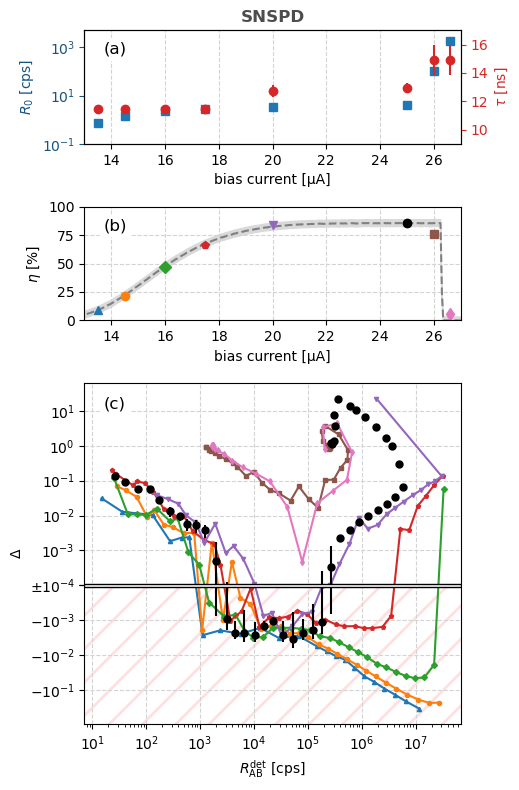

In [8]:
def PlotSNSPD():
    fig = plt.figure(figsize=(5, 7.7))
    gs = matplotlib.gridspec.GridSpec(3, 1, height_ratios=[1,1,3])
    
    R0_c = 'tab:blue'
    R0_c_thin = '#165480'
    tau_c = 'tab:red'
    m = ['^','o','D',"p",'v','o','s',"d"]
    subcap_size = 12
    
    # FIRST PLOT - dark counts and dead time
    
    ax01 = fig.add_subplot(gs[0])
    ax02 = ax01.twinx()
    
    ax01.grid(visible=True, axis='x', which='major', color='lightgray', linestyle='--')
    
    pl01 = ax01.errorbar(bias_vals, dc_SNSPD[0], yerr=dc_SNSPD[1], fmt='s', c=R0_c)
    pl02 = ax02.errorbar(bias_vals, tau_SNSPD[0], yerr=tau_SNSPD[1], fmt='o', c=tau_c)
    
    ax01.set_yscale('log')
    ax01.set_xlim(13,27)
    ax01.set_ylim(1e-1, 5e3)
    ax01.set_xlabel(r'bias current [μA]')
    ax01.set_ylabel(r'$R_0$ [cps]')
    ax01.yaxis.label.set_color(R0_c_thin)
    ax01.tick_params(axis='y', colors=R0_c_thin)
    ax02.set_ylabel(r'$\tau$ [ns]')
    ax02.yaxis.label.set_color(tau_c)
    ax02.tick_params(axis='y', colors=tau_c)
    ax02.set_ylim(9, 17)
    
    ax01.annotate('(a)', xy=(0.05, 0.90), xycoords='axes fraction', ha='left', va='top',
                  fontsize=subcap_size, bbox=dict(color='w', boxstyle='square, pad=0.2'))

    # SECOND PLOT - bias current

    ax1 = fig.add_subplot(gs[1])
    
    ax1.grid(visible=True, which='major', color='lightgray', linestyle='--')
    
    ax1.plot(*eff_specs, ls='--', c='gray')
    ax1.fill_between(eff_specs[0], eff_specs[1] - 3., eff_specs[1] + 3., color='0.85')
    
    for i in range(len(bias_vals)):
        clr = 'k' if (bias_vals[i] == 25.0) else None
        ax1.errorbar(bias_vals[i], eff_SNSPD[0][i], yerr=eff_SNSPD[1][i], color=clr, marker=m[i])
    
    ax1.set_xlim(13,27)
    ax1.set_ylim(0,100)
    ax1.set_xlabel(r'bias current [μA]')
    ax1.set_ylabel(r'$\eta$ [%]')
    
    ax1.annotate('(b)', xy=(0.05, 0.90), xycoords='axes fraction', ha='left', va='top',
                 fontsize=subcap_size, bbox=dict(color='w', boxstyle='square, pad=0.2'))

    # THIRD PLOT - nonlinearity

    ax2 = fig.add_subplot(gs[2])
    
    ax2.grid(visible=True, which='major', color='lightgray', linestyle='--')
    ax2.set_xscale('log')
    ax2.set_yscale('symlog', linthresh=1e-4, linscale=0.001)
    ax2.yaxis.set_major_formatter(FuncFormatter(symlog_ytick))
    
    ax2.set_xlabel(r'$R^{\mathrm{det}}_{\mathrm{AB}}$ [cps]')
    ax2.set_ylabel(r'$\Delta$')

    for rate, delta, derr, cur, mrkr in \
        zip(rate_means_SNSPD, delta_means_SNSPD, delta_errs_SNSPD, cur_str, m):
    
        if cur == '250':
            ax2.errorbar(rate*1e6, delta, yerr=derr, fmt=mrkr, ms=5., color='k')
        else:
            ax2.plot(rate*1e6, delta, marker=mrkr, ms=3)
    
    ax01.set_title('SNSPD', weight='bold', c='0.3')
    
    fig.tight_layout(pad=0., h_pad=1.)
    
    xb = ax2.get_xlim()
    yb = ax2.get_ylim()
    axes_break = patches.Rectangle((xb[0], -1.1e-4), xb[1]-xb[0],
                           2.2e-4, fc='w', ec='k', zorder = 3)
    ax2.add_patch(axes_break)    
    neg_hatches = patches.Rectangle((xb[0], yb[0]), xb[1]-xb[0],
                           0-yb[0], fc='w', ec='#ffe0e0', lw=0, hatch='/', zorder = 0)
    ax2.add_patch(neg_hatches)

    ax2.annotate('(c)', xy=(0.05, 0.96), xycoords='axes fraction', ha='left', va='top',
                 fontsize=subcap_size, bbox=dict(color='w', boxstyle='square, pad=0.2'))
    
    plt.show()
    
    return fig
    
fig_SNSPD = PlotSNSPD()